In [1]:
import sys  
sys.path.insert(1, '/scratch/gpfs/ls1546/icl_experiments/')

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import embedding
import transformer
import dataset_utils

In [3]:
#load MNIST
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
test_data = datasets.MNIST('../data', train=False,
                    transform=transform)

In [4]:
#augment MNIST with multiple tasks
n_tasks = 1
#including normal MNIST with no random matrix as well
aug_train = dataset_utils.AugmentedData(train_data,num_tasks=n_tasks,include_identity=True)
aug_test = dataset_utils.AugmentedData(test_data,num_tasks=n_tasks)
aug_test.adopt_transforms(aug_train) #make sure train & test tasks are the same

In [5]:
#instantiate model
model = transformer.ImageICLTransformer(d_model=64,device='cuda',block_size=100)
print(model)

using flash attention
Embedding Transformer with 816332 parameters, 210360 parameters in embedder & 604682 parameters in transformer


1875it [02:59, 10.44it/s]


1.8628766260669878


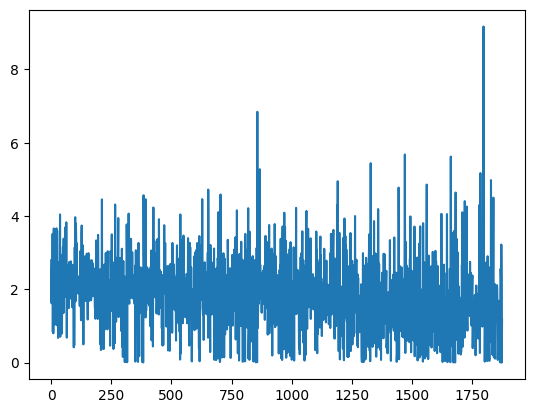

In [7]:
from tqdm import tqdm
#train the model to do MNIST classification

batch_size = 32
lr = 0.01
momentum = 0.9
epochs = 1
log_freq = 100
device = 'cuda'

model = model.to(device)

train_loader = torch.utils.data.DataLoader(dataset=aug_train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=aug_test, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50])

loss_history = []
for epoch in range(epochs):
    model.train()
    epoch_loss = [0]*(len(aug_train)//batch_size)
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        images = images.unsqueeze(1).unsqueeze(1)
        labels = labels.unsqueeze(1)
        B,T,C,W,H = images.shape
        images = images.reshape(T,B,C,W,H) #hack for now -- make batch dimension into sequence
        labels = labels.reshape(T,B)
        outputs = model((images,labels))
        pred = outputs[:,-1,:]
        loss = criterion(pred,labels[:,-1])
        loss.backward()
        optimizer.step()
        epoch_loss[i] = loss.item()

    lr_scheduler.step()
    loss_history += epoch_loss
    epoch_loss = np.array(epoch_loss)
    print(epoch_loss.mean())

loss_history = np.array(loss_history)
plt.plot(loss_history);

In [14]:
def test_model(model, dataset, batch_size=150, device='cuda'):
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    correct = 0
    model.eval()
    for i,(images, labels) in tqdm(enumerate(loader)):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1).unsqueeze(1)
        labels = labels.unsqueeze(1)
        outputs = model((images,labels))
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
    accuracy = 100 * (correct.item()) / len(dataset)
    print(accuracy)

In [15]:
test_model(model, aug_test) #80% test accuracy

67it [00:03, 17.09it/s]

98.0
